In [1]:
import torch
from torch import nn
from d2l import torch as d2l

网络结构修改：将所有激活函数由 sigmoid 改为 ReLU

In [2]:
lenet = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 10)
)

In [3]:
x = torch.rand((1, 1, 28, 28), dtype=torch.float32)
for layer in lenet:
    x: torch.Tensor = layer(x)
    print(layer.__class__.__name__, 'output shape: \t', x.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
ReLU output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
ReLU output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
ReLU output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
ReLU output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


## 加载数据集

In [4]:
batch_size = 256

In [5]:
from torch.utils import data
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

In [6]:
trans = transforms.ToTensor() # 将图片转为m*n*1张量
mnist_train = torchvision.datasets.MNIST(
    root='../data', train=True, transform=trans, download=True
)
mnist_test = torchvision.datasets.MNIST(
    root='../data', train=False, transform=trans, download=True
)

In [7]:
train_iter = data.DataLoader(mnist_train, batch_size=256)
test_iter = data.DataLoader(mnist_test, batch_size=256)

## 开始训练

In [8]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
lenet.apply(init_weights)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

In [9]:
gpu = torch.device('cuda:0')
gpu

device(type='cuda', index=0)

In [10]:
lr = 0.5
num_epochs = 20

In [11]:
lenet.to(gpu)
optimizer = torch.optim.SGD(lenet.parameters(), lr=lr)
loss = nn.CrossEntropyLoss()

In [12]:
def evaluate_accuracy(net, test_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()
        if device is not None:
            device = next(iter(net.parameters())).device
    
    correct_samples = 0
    total_samples = 0

    # 表示该计算过程不进行自动求导，节约计算资源
    with torch.no_grad():
        for x, y in test_iter:
            x = x.to(device)
            y = y.to(device)

            # 计算分类的正确数
            y_hat = net(x)
            correct_samples += d2l.accuracy(y_hat, y)
            total_samples += y.numel() # 计算 y 的总数
    
    return correct_samples / total_samples

In [13]:
for epoch in range(num_epochs):
    # Set the net to training mode
    lenet.train()
    # 累积器，对当前 epoch 累积 loss、正确分类数、总样本数
    metric = d2l.Accumulator(3) 
    

    for i, (x, y) in enumerate(train_iter):

        optimizer.zero_grad()
        x, y = x.to(gpu), y.to(gpu)
        y_hat = lenet(x)
        l = loss(y_hat, y)
        l.backward()
        # 通过 .step() 来更新网络的参数
        optimizer.step()

        with torch.no_grad():
            # 统计 loss，正确分类数，总样本数
            metric.add(l * x.shape[0], d2l.accuracy(y_hat, y), x.shape[0])

    train_loss = metric[0] / metric[2]; train_acc = metric[1] / metric[2]
    test_acc = evaluate_accuracy(lenet, test_iter, gpu)
    print(f'Epoch:{epoch + 1}, Loss: {train_loss}, Train ACC: {train_acc}, Test ACC: {test_acc}')

Epoch:1, Loss: 1.6763330135027568, Train ACC: 0.4149833333333333, Test ACC: 0.5661
Epoch:2, Loss: 0.2534020680983861, Train ACC: 0.9208333333333333, Test ACC: 0.9132
Epoch:3, Loss: 0.1172570169210434, Train ACC: 0.96385, Test ACC: 0.9504
Epoch:4, Loss: 0.08368137068549791, Train ACC: 0.9738833333333333, Test ACC: 0.9515
Epoch:5, Loss: 0.06663644522825878, Train ACC: 0.9788833333333333, Test ACC: 0.9635
Epoch:6, Loss: 0.05477057498693466, Train ACC: 0.9831333333333333, Test ACC: 0.9728
Epoch:7, Loss: 0.047078313433130584, Train ACC: 0.9848166666666667, Test ACC: 0.979
Epoch:8, Loss: 0.041072520330548284, Train ACC: 0.9871166666666666, Test ACC: 0.9782
Epoch:9, Loss: 0.03578942196344336, Train ACC: 0.9886, Test ACC: 0.981
Epoch:10, Loss: 0.032664076571663224, Train ACC: 0.9896666666666667, Test ACC: 0.9795
Epoch:11, Loss: 0.026642275309065978, Train ACC: 0.99165, Test ACC: 0.9795
Epoch:12, Loss: 0.024544355685512224, Train ACC: 0.9922333333333333, Test ACC: 0.9788
Epoch:13, Loss: 0.07147

## 网络验证

`Conv2D` 的输入必须是 4 维张量： Batch_size x Channel x Height x Width，因此测试单张图片时，必须转为 `(1, 1, 28, 28)` 的格式

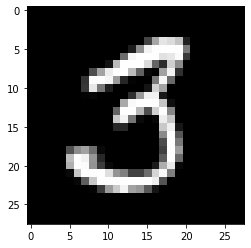

In [14]:
plt.imshow(mnist_train[1145][0].reshape(28, 28), cmap='gray')

In [15]:
img = mnist_train[1145][0].reshape(1, 1, 28, 28)
torch.argmax(lenet(img.to(gpu)))

tensor(3, device='cuda:0')

结论：将激活函数由 Sigmoid 改成 ReLU 之后，明显地提高了正确率